In [113]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
fd_001_train = pd.read_csv('C:/Users/Игорь/Downloads/nasa-cmaps/CMaps/train_FD001.txt',header=None,sep=' ')

In [3]:
fd_001_test = pd.read_csv('C:/Users/Игорь/Downloads/nasa-cmaps/CMaps/test_FD001.txt',header=None,sep=' ')

In [4]:
fd_001_train.drop(columns=[26,27],inplace=True)

In [5]:
fd_001_test.drop(columns=[26,27],inplace=True)

In [6]:
columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]

In [7]:
fd_001_train.columns = columns

In [8]:
fd_001_test.columns = columns

In [9]:
fd_001_train.head()

,unit_number,time_in_cycles,setting_1,setting_2,TRA,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [10]:
# удалим колонки с константными значениями
fd_001_train.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)


In [11]:
# удалим колонки с константными значениями
fd_001_test.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,16

## Подготовка тренировочных данных

In [14]:
# подготовка датафрейма с информацией по номеру цикла поломки
fd_RUL = fd_001_train.groupby('unit_number')['time_in_cycles'].max().reset_index()

In [15]:
fd_RUL = pd.DataFrame(fd_RUL)
fd_RUL.columns = ['unit_number','max']
fd_RUL.head()

,unit_number,max
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269


In [16]:
# создание в fd_001_train колонки RUL с информацией об оставшихся до поломки циклах
fd_001_train = fd_001_train.merge(fd_RUL, on=['unit_number'], how='left')
fd_001_train['RUL'] = fd_001_train['max'] - fd_001_train['time_in_cycles']
fd_001_train.drop(columns=['max'],inplace = True)

In [19]:
fd_001_train.head()

,unit_number,time_in_cycles,setting_1,setting_2,T24,T30,T50,P15,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


In [186]:
# Функция для подготовки масиивов X (features) и Y(labels) к обучению модели
def make_X_Y(start,end,dataset):
    fd_to_transform = dataset.copy()
    fd_to_transform['label'] = np.where((fd_to_transform['RUL'] < start) & (fd_to_transform['RUL'] >= end), 1, 0 )
    fd_to_transform.drop(columns = ['unit_number','RUL'],inplace = True)
    X = fd_to_transform.iloc[:,:18].to_numpy() 
    Y = fd_to_transform.iloc[:,18:].to_numpy()
    Y = np.ravel(Y)
    
    return X,Y

In [187]:
# Балансировка классов для улучшения работы классификатора
def balanced_X_Y(X,Y):
    ros = RandomOverSampler(random_state=0)
    ros.fit(X, Y)
    X_resampled, Y_resampled = ros.fit_sample(X, Y)
    return X_resampled, Y_resampled

In [188]:
def make_X_test(data):
    dataset = data.copy()
    test_max = dataset.groupby('unit_number')['time_in_cycles'].max().reset_index()
    test_max.columns = ['unit_number','max']
    dataset = dataset.merge(test_max, on=['unit_number'], how='left')
    test = dataset[dataset['time_in_cycles'] == dataset['max']].reset_index()
    test.drop(columns=['index','max','unit_number'],inplace = True)
    X_001_test = test.to_numpy()
    return X_001_test

In [231]:
def binary_classificator(model_name, train, test, window = [3,0], print_score = False):
    if model_name == 'forest':
        model = RandomForestClassifier(n_estimators=90 ,max_depth = 1, random_state=193)
    elif model_name == 'gaussianNB':
        model = GaussianNB()
    else:
        print('такой модели нет в списке')
        return
    X,Y = make_X_Y(window[0],window[1],train)
    X_resampled,Y_resampled = balanced_X_Y(X,Y)
    # Здесь делим данные на обучающую выборку и тестовую , test_size = 0.2 задает долю тестовой выборки = 20%
    X_train,X_test,y_train,y_test = train_test_split(X_resampled,Y_resampled,test_size = 0.2,random_state = 3)
    model.fit(X_train,y_train)
    y_pred_train = model.predict(X_test)
    
    if print_score:
        print(f'accuracy score {accuracy_score(y_test, y_pred_train)}')
        print(f'precision score {precision_score(y_test, y_pred_train)}')
        print(f'recall score {recall_score(y_test, y_pred_train)}')
        print(f'F1 score {f1_score(y_test, y_pred_train)}')
    
    X_real = make_X_test(test)
    return model.predict(X_real)

## Подготовим тестовые данные для классификации

Количество элементов до операции балансировки: 20631
Количество элементов после операции балансировки: 35400
 accuracy score 0.661723163841808
 precision score 0.616946343484566
 recall score 0.8450624290578888
 F1 score 0.7132079990420308


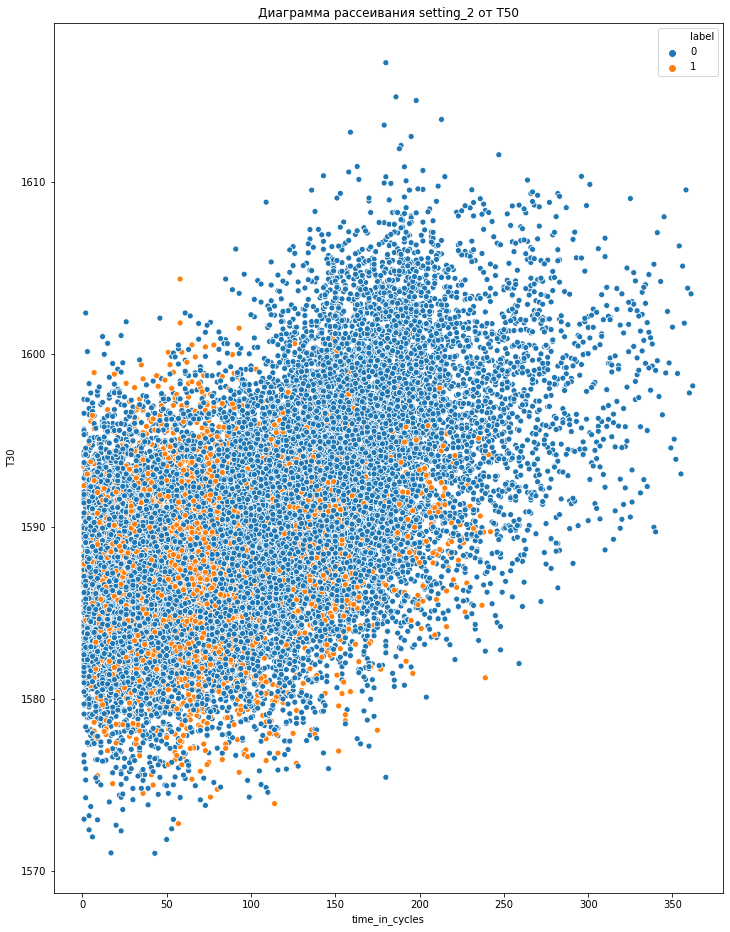

In [176]:
# предсказание для X_001_test, время до поломки = TTF =10
predicted = pd.DataFrame(binary_classificator('gaussianNB', fd_001_train, fd_001_test, window = [150,120]))

In [232]:
window_size = 25
RUL = pd.read_csv('C:/Users/Игорь/Downloads/nasa-cmaps/CMaps/RUL_FD001.txt',header=None,sep=' ')
RUL.drop(columns=[1],inplace =True)
RUL.columns = ['max']
RUL['unit_number'] = RUL.index + 1
pred = RUL
pred[f'0-{window_size}'] = pd.DataFrame(binary_classificator('forest',fd_001_train, fd_001_test, window = [window_size,0]))

Количество элементов до операции балансировки: 20631
Количество элементов после операции балансировки: 36262


In [233]:
for i in range(1,8):
    pred[f'{i*window_size}-{(i+1)*window_size}'] = pd.DataFrame(binary_classificator('forest',
                                                        fd_001_train, fd_001_test, window = [i+1,i]))
    

Количество элементов до операции балансировки: 20631
Количество элементов после операции балансировки: 41062
Количество элементов до операции балансировки: 20631
Количество элементов после операции балансировки: 41062
Количество элементов до операции балансировки: 20631
Количество элементов после операции балансировки: 41062
Количество элементов до операции балансировки: 20631
Количество элементов после операции балансировки: 41062
Количество элементов до операции балансировки: 20631
Количество элементов после операции балансировки: 41062
Количество элементов до операции балансировки: 20631
Количество элементов после операции балансировки: 41062
Количество элементов до операции балансировки: 20631
Количество элементов после операции балансировки: 41062


In [234]:
pred 

,max,unit_number,0-25,25-50,50-75,75-100,100-125,125-150,150-175,175-200
0,112,1,0,0,0,0,0,0,0,0
1,98,2,0,0,0,0,0,0,0,0
2,69,3,1,0,0,0,0,0,0,0
3,82,4,0,0,0,0,0,0,0,0
4,91,5,0,0,0,0,0,0,0,0
5,93,6,0,0,0,0,0,0,0,0
6,91,7,0,0,0,0,0,0,0,0
7,95,8,0,0,0,0,0,0,0,0
8,111,9,0,0,0,0,0,0,0,0
9,96,10,0,0,0,0,0,0,0,0


In [163]:
# Функция для подготовки масиивов X (features) и Y(labels) к обучению модели
def make_dataset(start,end,dataset):
    fd_to_transform = dataset.copy()
    fd_to_transform['label'] = np.where((fd_to_transform['RUL'] < start) & (fd_to_transform['RUL'] >= end), 1, 0 )
    df = fd_to_transform.drop(columns = ['unit_number','RUL'])
    X = df.iloc[:,:18].to_numpy() 
    Y = df.iloc[:,18:].to_numpy()
    Y = np.ravel(Y)
    
    return fd_to_transform

In [167]:
control_df = make_dataset(100,95,fd_001_train)

In [168]:
control_df[control_df['label'] == 1]

,unit_number,time_in_cycles,setting_1,setting_2,T24,T30,T50,P15,P30,Nf,...,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,RUL,label
92,1,93,0.0032,0.0002,642.85,1593.74,1408.48,21.61,554.07,2388.07,...,47.46,521.43,2388.08,8133.15,8.4210,392,38.86,23.2477,99,1
93,1,94,-0.0021,0.0002,642.45,1583.27,1404.94,21.61,553.86,2388.15,...,47.48,521.61,2388.07,8132.40,8.4524,393,38.85,23.3758,98,1
94,1,95,0.0019,0.0003,642.86,1577.60,1410.10,21.61,553.91,2388.02,...,47.38,521.92,2388.02,8131.63,8.4575,394,38.76,23.3269,97,1
95,1,96,-0.0034,0.0001,642.19,1584.07,1395.16,21.61,553.34,2388.07,...,47.39,521.66,2388.06,8130.69,8.4311,392,38.88,23.3255,96,1
96,1,97,0.0035,-0.0003,642.07,1595.77,1407.81,21.61,553.40,2388.09,...,47.46,521.67,2388.06,8128.74,8.4105,392,39.01,23.2963,95,1
379,2,188,0.0024,0.0002,642.64,1582.97,1402.72,21.61,554.26,2388.07,...,47.37,522.34,2388.04,8139.36,8.4124,392,38.82,23.3060,99,1
380,2,189,0.0003,0.0002,642.81,1583.54,1403.09,21.61,554.03,2388.03,...,47.42,521.70,2388.04,8141.68,8.4253,393,39.02,23.2923,98,1
381,2,190,0.0013,0.0004,642.48,1592.50,1405.73,21.61,554.40,2388.06,...,47.20,521.73,2388.03,8139.40,8.4128,393,39.04,23.2623,97,1
382,2,191,-0.0009,0.0004,642.23,1584.59,1407.64,21.61,553.42,2388.04,...,47.40,521.92,2388.05,8142.41,8.4694,393,38.93,23.3507,96,1
383,2,192,0.0003,0.0002,642.18,1589.95,1404.07,21.60,553.09,2388.03,...,47.49,521.70,2388.09,8141.81,8.4309,392,38.87,23.3049,95,1


## Выводы
Как можно видеть на этом этапе модель классификации показывает вполне адекватные предсказания. Верно идентифицированы все двигатели, у которых ресурс менее либо равен 10, максимальная ошибка для неверно идентифицированных при этом 28 (для двигателя 91) .В  дальнейшем предполагается оформление процесса подготовки данных и вывода предсказаний  в виде функции, принимающей на вход тренировочные , тестовые данные, а также параметры окна (время до отказа на шаге  i    [ TTF * i ; TTF * (i + 1) ] ), в результате будет формироваться dataframe "predicted", в котором колонками будут предсказания для "окна", до момента, когда все двигатели будут классифицированы или TTF * (i+1) станет больше максимального значения параметра RUL из тренировочных данных. Для вывода итогового результата будем использовать наименьший параметр "RUL<= TTF * (i+1)" датасета predicted (см. образец выше), при котором этот двигатель был положительно классифицирован (это следует из функции оценки качества алгоритма, описанной в https://github.com/ikucherevsky/netology_diplom/blob/master/Damage%20Propagation%20Modeling.pdf) То есть раннее предсказание поломки штрафуется меньше чем более позднее.


Кроме этого, возможно будет полезно исследовать смещение правильного ответа относительно предсказаний в несколько раз классифицированных двигателях для поиска оптимального алгоритма выбора итогового результата, вместо выбора по минимальному TTF 